# Evaluating Legal Literature Recommendations

This notebook contains the code to generate the figures and tables from our paper:

- [Tables](#Tables)
- [Figures](#Figures)
- [Samples](#Samples)


In [1]:
import re
import json
import os
import requests
import pickle
import pandas as pd
import logging
from pathlib import Path
from collections import defaultdict
from docsim.gold_standard import GoldStandard
from smart_open import open
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from IPython.core.display import display

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from gensim.models import KeyedVectors

from docsim.methods import RecSys
from docsim.methods.keyed_vector_based import KeyedVectorRecSys, MultiKeyedVectorRecSys, EnsembleKeyedVectorRecSys
from docsim.methods.text_based import TfIdfRecSys, Doc2VecRecSys, WeightedAvgWordVectorsRecSys
from docsim.methods.transformer_based import TransformerRecSys
from docsim.methods.graph_based import GraphEmbeddingRecSys
from docsim.environment import get_env
from docsim.experiment import Experiment
from utils import get_mean_avg_precision, get_avg_precision, highlight_max


logging.basicConfig(level=logging.INFO)

unable to import 'smart_open.gcs', disabling that module


In [2]:
data_dir = Path('./data')
figures_dir = Path('./figures')
models_dir = Path('./models')

env = get_env()
top_k = 5

metric_labels = {
    'support': 'Support',
    'ret': 'Ret.',
    'rel': 'Rel.',
    'p': 'P',
    'r': 'R',
    'avg_p': 'MAP',
    'reciprocal_rank': 'MRR',
    'coverage': 'Cov.'
}

input_exps = [
    ('ocb', 'OpenCaseBook'),
    ('wikisource', 'WikiSource')
]


/data/experiments/mostendorff/legal-docsim/environments
Environment detected: gpu_server2 (in default.yml)


In [3]:
#!rm ./models/ocb/cache/

In [4]:
exps = {}
evaluate = True   # change this

for name, pretty_name in input_exps:
    exp = Experiment(name=name, env=env, data_dir=data_dir, pretty_name=pretty_name)

    exp.load_data()
    exp.filter_docs()
    
    common_kwargs = dict(
        doc_id2idx=exp.doc_id2idx, 
        idx2doc_id=exp.idx2doc_id,
        print_progress=True,
        tqdm_notebook=True,
        top_k=top_k,
    )
    
    systems = exp.get_systems(common_kwargs)

    # Cache
    cache_dir = exp.models_dir / 'cache'
    
    # multi
    multi = MultiKeyedVectorRecSys(**common_kwargs)
    multi.train([exp.models_dir / 'poincare.w2v.txt', exp.models_dir / 'avg_fasttext_custom.w2v.txt'])
    assert multi.vector_size == 600
    
    systems['AvgFastText_custom||Poincaré'] = multi
    
    multi = MultiKeyedVectorRecSys(**common_kwargs)
    multi.train([exp.models_dir / 'longformer-large-4096-mean.w2v.txt', exp.models_dir / 'avg_fasttext_custom.w2v.txt'])
    assert multi.vector_size == 300+1024
    
    systems['AvgFastText_custom||Longformer-large'] = multi
    
    multi = MultiKeyedVectorRecSys(**common_kwargs)
    multi.train([exp.models_dir / 'longformer-large-4096-mean.w2v.txt', exp.models_dir / 'avg_fasttext_custom.w2v.txt'])
    assert multi.vector_size == 300+1024
    
    systems['AvgFastText_custom||Longformer-large'] = multi
    
    # ensemble
    ensemble = EnsembleKeyedVectorRecSys(**common_kwargs)
    ensemble.train([exp.models_dir / 'poincare.w2v.txt', exp.models_dir / 'avg_fasttext_custom.w2v.txt'])
    systems['AvgFastText_custom+Poincaré'] = ensemble
    
    ensemble = EnsembleKeyedVectorRecSys(**common_kwargs)
    ensemble.train([exp.models_dir / 'longformer-large-4096-mean.w2v.txt', exp.models_dir / 'avg_fasttext_custom.w2v.txt'])
    systems['AvgFastText_custom+Longformer-large'] = ensemble   
    
    if evaluate:
        # precompute similarity if possible
        for n in systems:
            if hasattr(systems[n], 'model') and hasattr(systems[n].model, 'init_sims'):
                #print(f'Precomputing for {n}')
                systems[n].model.init_sims(replace=True)

        df = exp.gs.evaluate(
            systems, 
            include_seeds=exp.get_included_seeds(), 
            show_progress=True, 
            tqdm_notebook=True,
            cache_dir=cache_dir
        )

        # Exclude zero-retrieved
        print(f'Before: {len(df):,}')

        for col in df.columns:
            if col.endswith('_ret'):
                df = df[df[col] == top_k]

        print(f'After: {len(df):,}')

        # Load meta data and join with results (id must be string)
        meta_df = pd.read_csv(exp.exp_dir / 'meta.csv', dtype={'id': 'str'}).set_index('id')

        exp.results_df = df.join(meta_df)
        exp.results_df.to_csv(data_dir / f'results_{exp.name}.csv')
    else:
        # load from disk
        exp.results_df = pd.read_csv(data_dir / f'results_{exp.name}.csv', index_col=0)

    exps[name] = exp


INFO:docsim.experiment:Documents loaded: 1,632
INFO:docsim.experiment:Unique documents in gold standard: 1,623
INFO:docsim.experiment:Documents after filtering: 1,590 (before 1,632)
INFO:gensim.models.utils_any2vec:loading projection weights from models/ocb/sroberta-large-nli-stsb-mean-tokens.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1590, 1024) matrix from models/ocb/sroberta-large-nli-stsb-mean-tokens.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/ocb/doc2vec.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1590, 300) matrix from models/ocb/doc2vec.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/ocb/doc2vec_512.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1590, 300) matrix from models/ocb/doc2vec_512.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/ocb/doc2vec_4096.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1590, 300) matrix from models/ocb/doc2vec_4096.w2v.txt
INFO:gensim

INFO:gensim.models.utils_any2vec:loading projection weights from models/ocb/ssentence_poincare3_legal-bert.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1590, 768) matrix from models/ocb/ssentence_poincare3_legal-bert.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/ocb/ssentence_longformer-base-4096.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1590, 768) matrix from models/ocb/ssentence_longformer-base-4096.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/ocb/ssentence_joint_aueb-legal-bert-base-uncased.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1590, 768) matrix from models/ocb/ssentence_joint_aueb-legal-bert-base-uncased.w2v.txt
INFO:docsim.experiment:Loaded systems: dict_keys(['sRoBERTa large-nli-stsb-mean-tokens', 'TF-IDF', 'Paragraph Vectors', 'Paragraph Vectors_512', 'Paragraph Vectors_4096', 'AvgGloVe', 'AvgGloVe_custom', 'AvgFastText', 'AvgFastText_custom', 'AvgFastText_custom_512', 'AvgFastText_custom_

INFO:docsim.gold_standard:Saving cache for "sRoBERTa large-nli-stsb-mean-tokens" in models/ocb/cache/sRoBERTa large-nli-stsb-mean-tokens.json
INFO:docsim.gold_standard:Saving cache for "TF-IDF" in models/ocb/cache/TF-IDF.json
INFO:docsim.gold_standard:Saving cache for "Paragraph Vectors" in models/ocb/cache/Paragraph Vectors.json
INFO:docsim.gold_standard:Saving cache for "Paragraph Vectors_512" in models/ocb/cache/Paragraph Vectors_512.json
INFO:docsim.gold_standard:Saving cache for "Paragraph Vectors_4096" in models/ocb/cache/Paragraph Vectors_4096.json
INFO:docsim.gold_standard:Saving cache for "AvgGloVe" in models/ocb/cache/AvgGloVe.json
INFO:docsim.gold_standard:Saving cache for "AvgGloVe_custom" in models/ocb/cache/AvgGloVe_custom.json
INFO:docsim.gold_standard:Saving cache for "AvgFastText" in models/ocb/cache/AvgFastText.json
INFO:docsim.gold_standard:Saving cache for "AvgFastText_custom" in models/ocb/cache/AvgFastText_custom.json
INFO:docsim.gold_standard:Saving cache for "Av

INFO:docsim.gold_standard:Saving cache for "AvgFastText_4096" in models/ocb/cache/AvgFastText_4096.json
INFO:docsim.gold_standard:Saving cache for "legal-bert-mean" in models/ocb/cache/legal-bert-mean.json
INFO:docsim.gold_standard:Saving cache for "ssentence_legal-bert" in models/ocb/cache/ssentence_legal-bert.json
INFO:docsim.gold_standard:Saving cache for "ssentence_Longformer large-4096" in models/ocb/cache/ssentence_Longformer large-4096.json
INFO:docsim.gold_standard:Saving cache for "ssentence_Poincaré_legal-bert" in models/ocb/cache/ssentence_Poincaré_legal-bert.json
INFO:docsim.gold_standard:Saving cache for "ssentence_Poincaré2_legal-bert" in models/ocb/cache/ssentence_Poincaré2_legal-bert.json
INFO:docsim.gold_standard:Saving cache for "ssentence_aueb-legal-BERT base-uncased" in models/ocb/cache/ssentence_aueb-legal-BERT base-uncased.json
INFO:docsim.gold_standard:Saving cache for "aueb-legal-BERT base-uncased-mean" in models/ocb/cache/aueb-legal-BERT base-uncased-mean.json


Before: 1,590
After: 1,329


INFO:docsim.experiment:Documents after filtering: 1,378 (before 64,003)
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/avg_fasttext_custom_512.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 300) matrix from models/wikisource/avg_fasttext_custom_512.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/doc2vec.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 300) matrix from models/wikisource/doc2vec.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/doc2vec_512.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 300) matrix from models/wikisource/doc2vec_512.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/doc2vec_4096.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 300) matrix from models/wikisource/doc2vec_4096.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/avg_glo

INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/poincare.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 300) matrix from models/wikisource/poincare.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/avg_fasttext_custom.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 300) matrix from models/wikisource/avg_fasttext_custom.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/longformer-large-4096-mean.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 1024) matrix from models/wikisource/longformer-large-4096-mean.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/avg_fasttext_custom.w2v.txt
INFO:gensim.models.utils_any2vec:loaded (1378, 300) matrix from models/wikisource/avg_fasttext_custom.w2v.txt
INFO:gensim.models.utils_any2vec:loading projection weights from models/wikisource/longformer-large-4096-mean.w2v.txt
INFO:

INFO:docsim.gold_standard:Saving cache for "AvgFastText_custom_512" in models/wikisource/cache/AvgFastText_custom_512.json
INFO:docsim.gold_standard:Saving cache for "TF-IDF" in models/wikisource/cache/TF-IDF.json
INFO:docsim.gold_standard:Saving cache for "Paragraph Vectors" in models/wikisource/cache/Paragraph Vectors.json
INFO:docsim.gold_standard:Saving cache for "Paragraph Vectors_512" in models/wikisource/cache/Paragraph Vectors_512.json
INFO:docsim.gold_standard:Saving cache for "Paragraph Vectors_4096" in models/wikisource/cache/Paragraph Vectors_4096.json
INFO:docsim.gold_standard:Saving cache for "AvgGloVe" in models/wikisource/cache/AvgGloVe.json
INFO:docsim.gold_standard:Saving cache for "AvgGloVe_custom" in models/wikisource/cache/AvgGloVe_custom.json
INFO:docsim.gold_standard:Saving cache for "AvgFastText" in models/wikisource/cache/AvgFastText.json
INFO:docsim.gold_standard:Saving cache for "AvgFastText_custom" in models/wikisource/cache/AvgFastText_custom.json
INFO:docs

INFO:docsim.gold_standard:Saving cache for "AvgFastText_custom||Longformer-large" in models/wikisource/cache/AvgFastText_custom||Longformer-large.json
INFO:docsim.gold_standard:Saving cache for "AvgFastText_custom+Poincaré" in models/wikisource/cache/AvgFastText_custom+Poincaré.json
INFO:docsim.gold_standard:Saving cache for "AvgFastText_custom+Longformer-large" in models/wikisource/cache/AvgFastText_custom+Longformer-large.json


Before: 1,378
After: 1,363


In [36]:
# Load from disk
try:
    if exps is None:
        exps = None
except NameError:
    pass

if exps is None:
    exps = {}

    for name, pretty_name in input_exps:
        exp = Experiment(name=name, env=env, data_dir=data_dir, pretty_name=pretty_name)
        exp.results_df = pd.read_csv(data_dir / f'results_{exp.name}.csv', index_col=0)

In [7]:
sorted(exp.get_systems(None, models_dir).keys())

['AvgFastText',
 'AvgFastText_4096',
 'AvgFastText_512',
 'AvgFastText_custom',
 'AvgFastText_custom+Longformer-large',
 'AvgFastText_custom+Poincaré',
 'AvgFastText_custom_4096',
 'AvgFastText_custom_512',
 'AvgFastText_custom||Longformer-large',
 'AvgFastText_custom||Poincaré',
 'AvgGloVe',
 'AvgGloVe_4096',
 'AvgGloVe_512',
 'AvgGloVe_custom',
 'AvgGloVe_custom_4096',
 'AvgGloVe_custom_512',
 'BERT base-cased',
 'BERT base-cased-mean',
 'BERT large-cased-mean',
 'BoostNE',
 'DeepWalk',
 'Longformer base-4096-mean',
 'Longformer large-4096-mean',
 'Node2Vec',
 'Paragraph Vectors',
 'Paragraph Vectors_4096',
 'Paragraph Vectors_512',
 'Poincaré',
 'RoBERTa base-mean',
 'RoBERTa large-mean',
 'TF-IDF',
 'Walklets',
 'legal-bert-mean',
 'sBERT base-nli-mean-tokens',
 'sBERT base-nli-stsb-mean-tokens',
 'sBERT large-nli-mean-tokens',
 'sBERT large-nli-stsb-mean-tokens',
 'sRoBERTa base-nli-mean-tokens',
 'sRoBERTa base-nli-stsb-mean-tokens',
 'sRoBERTa large-nli-mean-tokens',
 'sRoBERTa 

In [5]:
sorted_cols = [(exp.pretty_name, c) for n, exp in exps.items() for c in ['Rel.', 'P', 'R', 'MRR', 'MAP', 'Cov.']]
print(sorted_cols)

# custom order: term-based - transformers -  - citations
term_systems = [
    'TF-IDF',

    'Paragraph Vectors',
    #'Paragraph Vectors_512',
    #'Paragraph Vectors_4096',

    'AvgFastText',
    #'AvgFastText_512',
    #'AvgFastText_4096',
    
    'AvgFastText_custom',
    'AvgFastText_custom_512',
    'AvgFastText_custom_4096',

    'AvgGloVe',
    #'AvgGloVe_512',
    #'AvgGloVe_4096',
    
    'AvgGloVe_custom',    
    #'AvgGloVe_custom_512',    
    #'AvgGloVe_custom_4096',    
    
]
transformer_systems = [
    #'BERT base-cased',
    'BERT base-cased-mean',
    'BERT large-cased-mean',
    'legal-bert-mean',
    'aueb-legal-BERT base-uncased-mean',

    'Longformer base-4096-mean',
    'Longformer large-4096-mean',

    #'RoBERTa base-mean',
    'RoBERTa large-mean',

    #'sBERT base-nli-mean-tokens',
    #'sBERT base-nli-stsb-mean-tokens',
    'sBERT large-nli-mean-tokens',
    'sBERT large-nli-stsb-mean-tokens',
    #'sRoBERTa base-nli-mean-tokens',
    #'sRoBERTa base-nli-stsb-mean-tokens',
    'sRoBERTa large-nli-mean-tokens',
    #'sRoBERTa large-nli-stsb-mean-tokens',
]
graph_systems = [
    'BoostNE',
    'DeepWalk',
    #'Node2Vec',
    'Poincaré',
    'Walklets',
]
hybrid_systems = [
    'AvgFastText_custom||Poincaré',
    'AvgFastText_custom||Longformer-large',
    'AvgFastText_custom+Poincaré',
    'AvgFastText_custom+Longformer-large',   
    # Excluded due to bad performance
    #'ssentence_legal-bert',
    #'ssentence_Longformer large-4096',
    #'ssentence_Longformer base-4096',
    
    #'ssentence_Poincaré_legal-bert',
    #'ssentence_Poincaré2_legal-bert',
    #'ssentence_Poincaré3_legal-bert',
    
    'ssentence_aueb-legal-BERT base-uncased',
    #'ssentence_joint_aueb-legal-BERT base-uncased',
    
    
    
]

sorted_systems = term_systems + transformer_systems + graph_systems + hybrid_systems

[('OpenCaseBook', 'Rel.'), ('OpenCaseBook', 'P'), ('OpenCaseBook', 'R'), ('OpenCaseBook', 'MRR'), ('OpenCaseBook', 'MAP'), ('OpenCaseBook', 'Cov.'), ('WikiSource', 'Rel.'), ('WikiSource', 'P'), ('WikiSource', 'R'), ('WikiSource', 'MRR'), ('WikiSource', 'MAP'), ('WikiSource', 'Cov.')]


In [6]:
vector_size_label = 'Dim.'

# Overall 
overall_rows = []

for exp_name, exp in exps.items():
    df = exp.results_df
    corpus_size = len(set(exp.gs.df.seed_id.values.tolist() +  exp.gs.df.target_id.values.tolist()))

    for name, rs in exp.get_systems(None).items():
        if name in ['nodesketch']:  # exclude
            continue
            
        # Coverage
        ret_docs = set([r for seed_id, seed_rets in exp.gs.ret_docs_by_system_and_seed[name].items() for r in seed_rets])
        coverage = len(ret_docs) / corpus_size
        
        overall_rows.append({
            'Experiment': exp.pretty_name,
            'System': name,
            vector_size_label: rs.vector_size,
            'ret': df[f'{name}_ret'].mean(),
            'rel': round(df[f'{name}_rel'].mean(), 2),
            'p': df[f'{name}_p'].mean(),
            'r': df[f'{name}_r'].mean(),
            'avg_p': df[f'{name}_avg_p'].mean(),
            'reciprocal_rank': df[f'{name}_reciprocal_rank'].mean(),       
            'coverage': coverage,
            
            #'std_ap': df[f'{method}_avg_p'].std(),
        })

overall_df = pd.DataFrame(overall_rows).set_index(['System', 'Experiment', ]).unstack()\
    .swaplevel(0, 1, 1).sort_index(1)\
    .rename(columns=metric_labels)

overall_df.insert(0, vector_size_label, overall_df[(exp.pretty_name, vector_size_label)].values)

overall_df = overall_df\
    .drop('Ret.', axis=1, level=1).drop(vector_size_label, axis=1, level=1)\
    .reindex([(vector_size_label, '')] + sorted_cols, axis=1)\
    .reindex(sorted_systems)  # sorted_systems

overall_df[vector_size_label] = overall_df[vector_size_label].astype('int64')

In [7]:
overall_df

Experiment                                Dim. OpenCaseBook            \
                                                       Rel.         P   
System                                                                  
TF-IDF                                  500000         1.60  0.320090   
Paragraph Vectors                          300         2.78  0.555004   
AvgFastText                                300         2.66  0.531828   
AvgFastText_custom                         300         2.87  0.573664   
AvgFastText_custom_512                     300         1.97  0.393679   
AvgFastText_custom_4096                    300         2.76  0.551843   
AvgGloVe                                   300         2.68  0.536494   
AvgGloVe_custom                            300         2.82  0.564184   
BERT base-cased-mean                       768         1.26  0.252822   
BERT large-cased-mean                     1024         1.35  0.270128   
legal-bert-mean                            768         1.47  0.294808   
aueb-legal-BERT base-uncased-mean          768         1.66  0.331076   
Longformer base-4096-mean                  768         1.91  0.382393   
Longformer large-4096-mean                1024         2.09  0.418510   
RoBERTa large-mean                        1024         1.52  0.304891   
sBERT large-nli-mean-tokens               1024         1.03  0.206020   
sBERT large-nli-stsb-mean-tokens          1024         0.98  0.196388   
sRoBERTa large-nli-mean-tokens            1024         0.92  0.183145   
BoostNE                                    300         1.29  0.257788   
DeepWalk                                   300         1.34  0.267419   
Poincaré                                   300         2.24  0.447103   
Walklets                                   300         2.24  0.447856   
AvgFastText_custom||Poincaré               600         2.36  0.472686   
AvgFastText_custom||Longformer-large      1324         2.26  0.451467   
AvgFastText_custom+Poincaré                600         2.85  0.570655   
AvgFastText_custom+Longformer-large       1324         2.09  0.418510   
ssentence_aueb-legal-BERT base-uncased     768         2.19  0.438375   

Experiment                                                            \
                                               R       MRR       MAP   
System                                                                 
TF-IDF                                  0.032370  0.363394  0.019705   
Paragraph Vectors                       0.056271  0.729345  0.048671   
AvgFastText                             0.052964  0.713318  0.044964   
AvgFastText_custom                      0.058611  0.739391  0.050058   
AvgFastText_custom_512                  0.036630  0.591071  0.028200   
AvgFastText_custom_4096                 0.053994  0.726611  0.045363   
AvgGloVe                                0.054115  0.701693  0.046150   
AvgGloVe_custom                         0.056624  0.724317  0.048260   
BERT base-cased-mean                    0.020547  0.428367  0.014657   
BERT large-cased-mean                   0.022009  0.443341  0.016066   
legal-bert-mean                         0.024563  0.482305  0.018220   
aueb-legal-BERT base-uncased-mean       0.027797  0.505618  0.021464   
Longformer base-4096-mean               0.033287  0.571608  0.025768   
Longformer large-4096-mean              0.038779  0.613531  0.031116   
RoBERTa large-mean                      0.025826  0.480875  0.019080   
sBERT large-nli-mean-tokens             0.018067  0.352295  0.013299   
sBERT large-nli-stsb-mean-tokens        0.017799  0.338437  0.012826   
sRoBERTa large-nli-mean-tokens          0.015580  0.320880  0.010644   
BoostNE                                 0.022485  0.441999  0.016198   
DeepWalk                                0.027510  0.473025  0.020903   
Poincaré                                0.043816  0.629483  0.036414   
Walklets                                0.043058  0.636280  0.034929   
AvgFastTe

# Tables

In [58]:
with pd.option_context('precision', 4):
    # .sort_values('MAP')
    # filter by group
    for needed_systems in [term_systems, transformer_systems, graph_systems, hybrid_systems]:
        display(overall_df[overall_df.index.isin(needed_systems)].style.apply(highlight_max))
    

In [59]:
# Overall
with pd.option_context('precision', 4):
    display(overall_df.style.apply(highlight_max))

In [74]:
len(overall_df)

27

In [73]:
header_tex = r'''
\setlength{\tabcolsep}{3pt} % Default value: 6pt
\renewcommand{\arraystretch}{1.1} % Default value: 1

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
 \multirow{3}{*}{\textbf{Method}}  &  {} & \multicolumn{6}{c}{\textbf{\ocb}} & \multicolumn{6}{c}{\textbf{\ws}} \\
 \cmidrule(lr){3-8}
\cmidrule(lr){9-14}
{} &   Size &       Rel. &      Prec. &      Recall &    MRR &    MAP & Cov. &      Rel. &      Prec. &      Recall &    MRR &    MAP & Cov. \\  
'''

footer_tex = r'''
\\\bottomrule
\end{tabular}
'''

with pd.option_context('precision', 3):    
    # print latex
    #.replace('AvgGloVe\_custom', r'AvgGloVe$|_{\text{OCB+WS}}$')\
    overall_tex = overall_df.to_latex()\
        .replace('-mean', '')\
        .replace('-tokens', '')\
        .replace('-cased', '')\
        .replace('-4096', '')\
        .replace('Paragraph Vectors\_4096', 'Paragraph Vectors$|^{4096}$').replace('Paragraph Vectors\_512', 'Paragraph Vectors$|^{512}$')\
        .replace('AvgGloVe\_custom', r'\gloVeLegal')\
        .replace('AvgFastText\_custom ', r'\fastTextLegal ')\
        .replace('AvgFastText\_custom\_512 ', r'\fastTextLegal (512)')\
        .replace('AvgFastText\_custom\_4096 ',  r'\fastTextLegal (4096)')\
        .replace('AvgFastText\_custom||Poincaré', r'\poincareCatFastTextLegal')\
        .replace('AvgFastText\_custom||Longformer-large', r'\longformerCatFastTextLegal')\
        .replace('AvgFastText\_custom+Poincaré', r'\poincareSumFastTextLegal')\
        .replace('AvgFastText\_custom+Longformer-large', r'\poincareSumLongformer')\
        .replace('AvgGloVe', r'\gloVe')\
        .replace('AvgFastText', r'\fastText')\
        .replace('ssentence\_aueb-legal-BERT base-uncased', r'sLegal-AUEB-BERT-base')\
        .replace('aueb-legal-BERT base-uncased', r'Legal-AUEB-BERT-base')\
        .replace('legal-bert', 'Legal-JHU-BERT-base')

    # extract body
    body_tex = overall_tex.split('\\midrule', 2)[1].split('\\bottomrule', 2)[0].strip() 

    
#    body_tex = body_tex.replace('BERT base ', r'\midrule BERT base ')
#    body_tex = body_tex.replace('BERT base ', r'\midrule BERT base ')
    
print(header_tex)

for i, row in enumerate(body_tex.splitlines()):
    # inser midrules
    if row.startswith('TF-IDF ') or row.startswith('BERT base ') \
        or row.startswith('BoostNE ') or row.startswith('\poincareCatFastTextLegal'):
        print(r'\midrule')
        
    if (i % 2) == 0:
        print(r'\rowcolor{Gray} ')
    
    print(row)

print(footer_tex)


\setlength{\tabcolsep}{3pt} % Default value: 6pt
\renewcommand{\arraystretch}{1.1} % Default value: 1

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 \multirow{3}{*}{\textbf{Method}}  &  {} & \multicolumn{5}{c}{\textbf{\ocb}} & \multicolumn{5}{c}{\textbf{\ws}} \\
 \cmidrule(lr){3-7}
\cmidrule(lr){8-12}
{} &   Size &       Rel. &      Prec. &      Recall &    MRR &    MAP &      Rel. &      Prec. &      Recall &    MRR &    MAP \\  

\midrule
\rowcolor{Gray} 
TF-IDF                                 &  500000 &         1.60 &  0.320 &  0.032 &  0.363 &  0.020 &  0.487 &       1.59 &  0.318 &  0.026 &  0.389 &  0.015 &  0.446 \\
Paragraph Vectors                      &     300 &         2.78 &  0.555 &  0.056 &  0.729 &  0.049 &  0.892 &       2.39 &  0.477 &  0.036 &  0.629 &  0.030 &  0.841 \\
\rowcolor{Gray} 
\fastText                            &     300 &         2.66 &  0.532 &  0.053 &  0.713 &  0.045 &  0.811 &       2.11 &  0.422 &  0.031 &  0.581 &  0.025 &  0.772 \\
\fastTextLegal    

# Figures

In [71]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE+1)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE+1)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE+1)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [91]:
import matplotlib.patches as mpatches
from matplotlib.container import ErrorbarContainer

# Evaluate by meta data
def clean_system_name(n):
    return n.replace(' large-nli-mean-tokens', '')\
        .replace(' large-4096-mean', '-large')\
        .replace(' large-mean', '-large')\
        .replace('legal-bert-mean', 'Legal-JHU-BERT-base')\
        .replace('aueb-legal-BERT base-uncased-mean', 'Legal-AUEB-BERT-base')\
        .replace('AvgFastText_custom+Poincaré', 'Poincaré + fastText Legal')\
        .replace('AvgFastText_custom||Poincaré', 'Poincaré || fastText Legal')\
        .replace('_custom', ' Legal')\
        .replace('AvgGloVe', 'GloVe')\
        .replace('AvgFastText', 'fastText')\
        .replace('_', '-')
    
        
def get_performance_figure(_df, system_names, meta_col, xlabel, 
                           selected_systems=None, system_styles=None, df_slice=None, 
                           save_file_path=None, figsize=(8, 4), legend_n_col=4, buckets_count=10, metric='avg_p', y_label=None):
    if df_slice:
        _df = _df[df_slice]
    
    bins, s = pd.qcut(_df[meta_col], q=buckets_count, retbins=True, duplicates='drop')

    if selected_systems:
        system_names = [s for s in system_names if s in selected_systems]
    
    metric_cols = [f'{s}_{metric}' for s in system_names]
    #print(metric_cols)
    xdf = _df.groupby(bins)[metric_cols].mean() # MAP or MRR

    if buckets_count != len(xdf):
        logger.warning('Final bucket count does not match requested bucket count')
    
    fig = plt.figure(figsize=figsize)

    ax = xdf.plot(    
        kind='bar', 
        rot=0,
        width=0.7,
        alpha=0.9,
        ax=fig.gca(),
        #color=['lightcoral', 'red', 'darkred'],
        edgecolor=['black'],
        #linewidth=1,
    )
    
    if system_styles:
        for container in ax.containers:
             if not isinstance(container, ErrorbarContainer):
                for needle in system_styles:
                    l = container.get_label().replace('_' + metric, '')
                    
                    if needle == l:  
                        style = system_styles[needle]
                        for patch in container.patches:
                            if 'color' in style:
                                patch.set_color(style['color'])
                            if 'hatch' in style:
                                patch.set_hatch(style['hatch'])
                            if 'linewidth' in style:
                                patch.set_linewidth(style['linewidth'])
                            if 'edgecolor' in style:
                                patch.set_edgecolor(style['edgecolor'])
                            else:
                                patch.set_edgecolor('black')
                        
    
    """
    for container, hatch in zip([c for c in ax.containers if not isinstance(c, ErrorbarContainer)], ("//", "//", '', '')):
        print(container.get_label())
        for patch in container.patches:
            patch.set_hatch(hatch)
    """
    
    legend_labels = [clean_system_name(n) for n in system_names]
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.25,
                     box.width, box.height * 0.75])

    ax.legend(legend_labels, ncol=legend_n_col, loc='upper center', 
              fancybox=True, shadow=False, bbox_to_anchor=(0.5, 1.3), )
    #ax.set_xticks(bins.cat.categories)
    ax.set_xticklabels([f'({int(i.left)}, {int(i.right)}]' for i in bins.cat.categories])
    ax.set_xlabel(xlabel % len(xdf))
    ax.set_ylabel(y_label if y_label else metric_labels[metric])

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')

    #plt.grid(True)
    plt.tight_layout()
    #plt.imshow(image, interpolation='nearest')
    
    if save_file_path:
        pdf_dpi = 300
        
        logger.info(f'Saved to {save_file_path}')
        plt.savefig(save_file_path, bbox_inches='tight', dpi=pdf_dpi)
    
    plt.show()
    
    return xdf


In [92]:
pretrained_hatch = '//'
fixed_length_hatch = '\\\\' 
tf_hatch = 'x'

sys_styles = {
    'TF-IDF': dict(color='lightcoral'),
        
    'Paragraph Vectors': dict(color='yellow'),
    'Paragraph Vectors_4096': dict(color='yellow', hatch=fixed_length_hatch),
    'Paragraph Vectors_512': dict(color='yellow', hatch=fixed_length_hatch),

    'AvgFastText': dict(color='darkred', hatch=pretrained_hatch),
    'AvgFastText_custom': dict(color='red'),
    'AvgFastText_custom_512': dict(color='red', hatch=fixed_length_hatch),
    'AvgFastText_custom_4096': dict(color='red', hatch=fixed_length_hatch),    
    
    'AvgGloVe': dict(color='darkorange', hatch=pretrained_hatch),
    'AvgGloVe_custom': dict(color='darkorange'),

    'BERT base-cased': dict(color='skyblue', hatch=tf_hatch),
    'BERT base-cased-mean': dict(color='lightskyblue', hatch=tf_hatch),
    'BERT large-cased-mean': dict(color='steelblue', hatch=tf_hatch),
    
    'legal-bert-mean': dict(color='purple', hatch=tf_hatch),
    'aueb-legal-BERT base-uncased-mean': dict(color='purple', hatch=tf_hatch),
    

    'Longformer base-4096-mean': dict(color='cornflowerblue', hatch=tf_hatch),
    'Longformer large-4096-mean': dict(color='royalblue', hatch=tf_hatch),

    'RoBERTa base-mean': dict(color='blue', hatch=tf_hatch),
    'RoBERTa large-mean': dict(color='blue', hatch=tf_hatch),


    'sBERT base-nli-mean-tokens': dict(color='violet', hatch=tf_hatch),
    'sBERT large-nli-mean-tokens': dict(color='darkviolet', hatch=tf_hatch),

    'BoostNE': dict(color='forestgreen'),
    'DeepWalk': dict(color='limegreen'),
    'Node2Vec': dict(color='darkgreen'),
    'Poincaré': dict(color='darkseagreen'),
    'Walklets': dict(color='aqua'),
    
    'AvgFastText_custom+Poincaré': dict(color='dimgrey', hatch=''),
    'AvgFastText_custom||Poincaré': dict(color='silver', hatch=''),

}

import matplotlib
"""
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
"""

"\nfont = {'family' : 'normal',\n        'weight' : 'normal',\n        'size'   : 20}\n\nmatplotlib.rc('font', **font)\n"

In [93]:
exp.results_df.columns.tolist()

['rel_docs_count',
 'AvgFastText_custom_512_ret',
 'AvgFastText_custom_512_rel',
 'AvgFastText_custom_512_p',
 'AvgFastText_custom_512_r',
 'AvgFastText_custom_512_avg_p',
 'AvgFastText_custom_512_reciprocal_rank',
 'TF-IDF_ret',
 'TF-IDF_rel',
 'TF-IDF_p',
 'TF-IDF_r',
 'TF-IDF_avg_p',
 'TF-IDF_reciprocal_rank',
 'Paragraph Vectors_ret',
 'Paragraph Vectors_rel',
 'Paragraph Vectors_p',
 'Paragraph Vectors_r',
 'Paragraph Vectors_avg_p',
 'Paragraph Vectors_reciprocal_rank',
 'Paragraph Vectors_512_ret',
 'Paragraph Vectors_512_rel',
 'Paragraph Vectors_512_p',
 'Paragraph Vectors_512_r',
 'Paragraph Vectors_512_avg_p',
 'Paragraph Vectors_512_reciprocal_rank',
 'Paragraph Vectors_4096_ret',
 'Paragraph Vectors_4096_rel',
 'Paragraph Vectors_4096_p',
 'Paragraph Vectors_4096_r',
 'Paragraph Vectors_4096_avg_p',
 'Paragraph Vectors_4096_reciprocal_rank',
 'AvgGloVe_ret',
 'AvgGloVe_rel',
 'AvgGloVe_p',
 'AvgGloVe_r',
 'AvgGloVe_avg_p',
 'AvgGloVe_reciprocal_rank',
 'AvgGloVe_custom_ret

INFO:__main__:Saved to figures/ocb_word_count.pdf


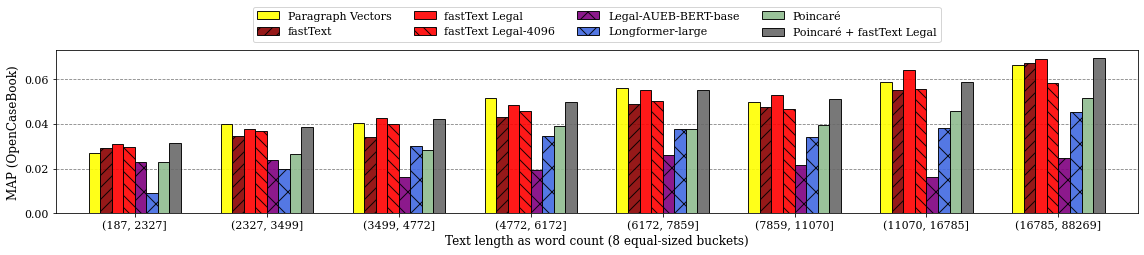

INFO:__main__:Saved to figures/wikisource_word_count.pdf


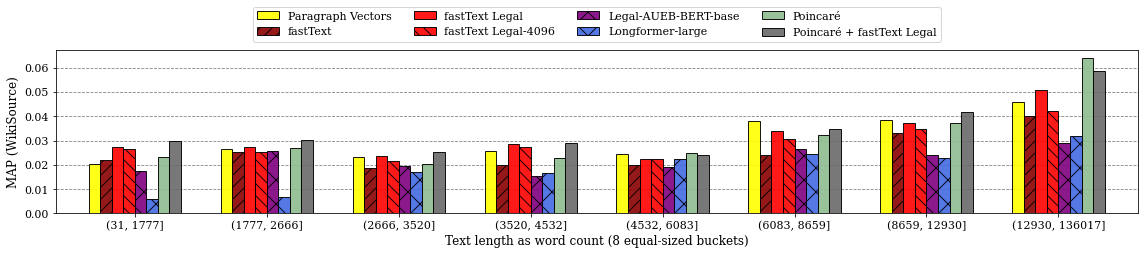

In [94]:
sys_word_count = [
    # word count
#    'TF-IDF', 
#    'sBERT large-nli-mean-tokens',
    'aueb-legal-BERT base-uncased-mean',
    #    'legal-bert-mean',
##    'RoBERTa large-mean',
    'Longformer large-4096-mean', 
    'Paragraph Vectors',
    
     #'AvgGloVe_custom',
    #'Doc2Vec_512',
#     'AvgGloVe',
#     'AvgGloVe_custom_512',
#     'AvgGloVe_custom_4096',
    'AvgFastText',
    'AvgFastText_custom',
        #'AvgFastText_custom_512',
        'AvgFastText_custom_4096',
    #'Walklets',
    'Poincaré',
    'AvgFastText_custom+Poincaré',
    #'AvgFastText_custom||Poincaré'
]


#matplotlib.rc('font', **font)

for exp_name, exp in exps.items():
    df = exp.results_df
    get_performance_figure(df, sorted_systems, 
                           'word_count', 'Text length as word count (%s equal-sized buckets)', 
                           save_file_path=figures_dir / f'{exp.name}_word_count.pdf',
                           buckets_count=8,
                           y_label=f'MAP ({exp.pretty_name})',
                           figsize=(16, 3), selected_systems=sys_word_count, system_styles=sys_styles)
    #break

In [112]:
exps['wikisource'].results_df.columns

Index(['rel_docs_count', 'AvgFastText_custom_512_ret',
       'AvgFastText_custom_512_rel', 'AvgFastText_custom_512_p',
       'AvgFastText_custom_512_r', 'AvgFastText_custom_512_avg_p',
       'AvgFastText_custom_512_reciprocal_rank', 'TF-IDF_ret', 'TF-IDF_rel',
       'TF-IDF_p',
       ...
       'category', 'text_length', 'name', 'decision_year', 'judges',
       'cites_to_count', 'ingoing_citation_count', 'outgoing_citation_count',
       'word_count', 'edges_count'],
      dtype='object', length=270)

INFO:__main__:Saved to figures/ocb_cits.pdf


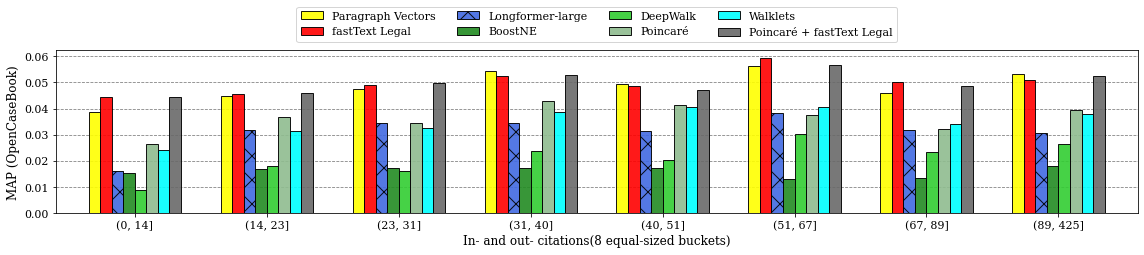

INFO:__main__:Saved to figures/wikisource_cits.pdf


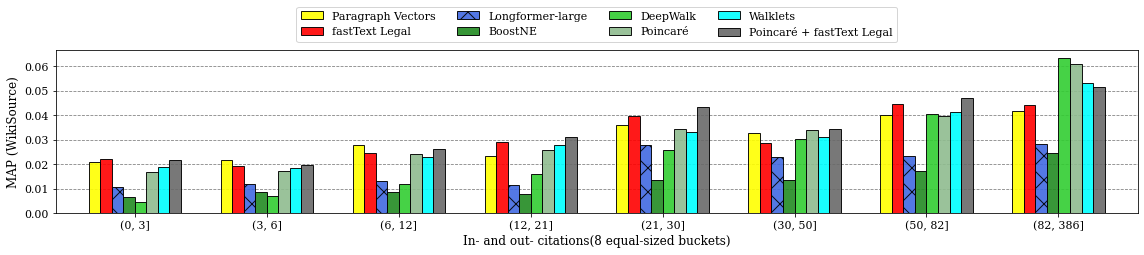

In [95]:

sys_cits = [
    # cits
    #'TF-IDF',
    'Paragraph Vectors',
    'Longformer large-4096-mean', 
    'AvgFastText_custom',
     'BoostNE',
     'DeepWalk',
     #'Node2Vec',
     'Poincaré',
     'Walklets',
    'Poincaré',
    'AvgFastText_custom+Poincaré',
]

for exp_name, exp in exps.items():
    get_performance_figure(exp.results_df, sorted_systems, 
                           'edges_count', 'In- and out- citations(%s equal-sized buckets)', 
                           save_file_path=figures_dir / f'{exp.name}_cits.pdf',
                           buckets_count=8,
                           y_label=f'MAP ({exp.pretty_name})',
                           figsize=(16, 3), selected_systems=sys_cits, system_styles=sys_styles)
    


INFO:__main__:Saved to figures/ocb_year.pdf


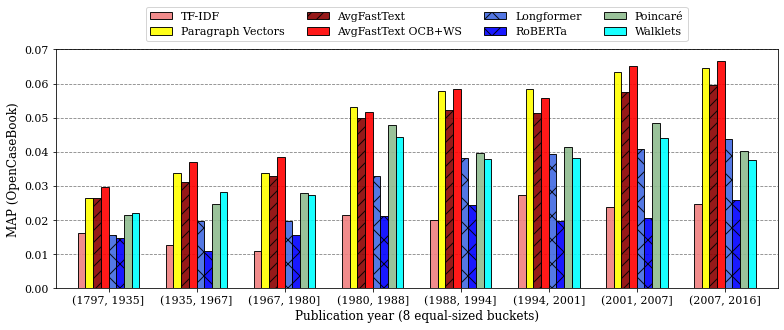

INFO:__main__:Saved to figures/wikisource_year.pdf


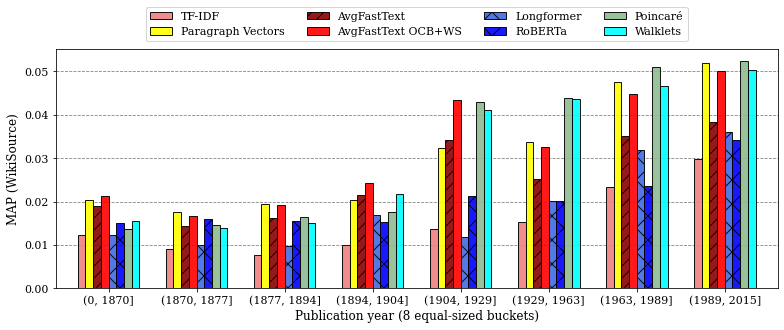

In [77]:
sys_year = [
    'TF-IDF', 
    'RoBERTa large-mean',
    'Longformer large-4096-mean', 
    'Paragraph Vectors',
    'AvgFastText',
    'AvgFastText_custom',
    'Walklets',
    'Poincaré',
]

for exp_name, exp in exps.items():
        
    get_performance_figure(exp.results_df, sorted_systems, 
                            'decision_year', 'Publication year (%s equal-sized buckets)', 
                           save_file_path=figures_dir / f'{exp.name}_year.pdf',
                           buckets_count=8,
                           y_label=f'MAP ({exp.pretty_name})',
                           figsize=(11, 4), selected_systems=sys_year, system_styles=sys_styles)
    

# Performance by topic (category / case book)

In [28]:
#TODO add `topic` to gold standard
exps['wikisource'].gs.df

,seed_id,target_id,label
0,86137,88695,United States Supreme Court decisions on treaties
1,86137,98239,United States Supreme Court decisions on treaties
2,86137,112574,United States Supreme Court decisions on treaties
3,86137,112247,United States Supreme Court decisions on treaties
4,86137,93298,United States Supreme Court decisions on treaties
...,...,...,...
200205,145777,97575,United States Supreme Court decisions on the S...
200206,88122,88360,The Legal Tender Cases
200207,88360,88122,The Legal Tender Cases
200208,100926,105018,United States Supreme Court decisions on Artic...


In [29]:
sorted_systems

['TF-IDF',
 'Paragraph Vectors',
 'Paragraph Vectors_512',
 'Paragraph Vectors_4096',
 'AvgFastText',
 'AvgFastText_custom',
 'AvgFastText_custom_512',
 'AvgFastText_custom_4096',
 'AvgGloVe',
 'AvgGloVe_custom',
 'BERT base-cased-mean',
 'BERT large-cased-mean',
 'Longformer base-4096-mean',
 'Longformer large-4096-mean',
 'RoBERTa base-mean',
 'RoBERTa large-mean',
 'sBERT base-nli-mean-tokens',
 'sBERT base-nli-stsb-mean-tokens',
 'sBERT large-nli-mean-tokens',
 'sBERT large-nli-stsb-mean-tokens',
 'sRoBERTa base-nli-mean-tokens',
 'sRoBERTa base-nli-stsb-mean-tokens',
 'sRoBERTa large-nli-mean-tokens',
 'sRoBERTa large-nli-stsb-mean-tokens',
 'BoostNE',
 'DeepWalk',
 'Node2Vec',
 'Poincaré',
 'Walklets',
 'AvgFastText_custom+Poincaré']

In [30]:
# show samples for these systems
sys_topics = [
    'TF-IDF', 
    'Paragraph Vectors',
    #'Longformer large-4096-mean', 
    'AvgFastText_custom',
    'Poincaré',
]
metric = 'avg_p'

topic_system_names = [s for s in sorted_systems if s in sys_topics]

#metric_cols = [ for s in system_names]
rel_col = 'Silver docs'
# Table
for n, exp in exps.items():
    if n == 'wikisource':
        group = exp.results_df.groupby(['category'])

        group_df = group['rel_docs_count'].mean().rename(rel_col).to_frame()

        for s in topic_system_names:
            metric_col = f'{s}_{metric}'
            group_df = group_df.join(group[metric_col].mean().rename(s).to_frame())
        
        #with open(exp.exp_dir / 'map_by_category.csv', 'w') as f:
        #    group_df.to_csv(f)

        with pd.option_context('precision', 4):
            # top 3
            display(group_df.sort_values([rel_col], ascending=False)[:3])

            # mid 3
            mid = round(len(group_df) / 2)
            #print(group_df)
            display(group_df.sort_values([rel_col], ascending=False)[mid:mid+3])

            # low 3
            display(group_df.sort_values([rel_col], ascending=False)[-3:])
            print(len(group_df))
            
#topic_df

,Silver docs,TF-IDF,Paragraph Vectors,AvgFastText_custom,Poincaré
category,,,,,
United States Supreme Court decisions on treaties,223.0000,0.0057,0.0133,0.0127,0.0092
United States Supreme Court decisions on due process,202.0797,0.0035,0.0069,0.0075,0.0079
United States Supreme Court decisions on securities,160.3529,0.0095,0.0116,0.0102,0.0084


,Silver docs,TF-IDF,Paragraph Vectors,AvgFastText_custom,Poincaré
category,,,,,
United States Supreme Court decisions on the right to travel,53.0000,0.0000,0.0010,0.0095,0.0238
United States Supreme Court decisions on elections,51.8182,0.0593,0.1184,0.1413,0.1082
United States Supreme Court decisions on Article III,51.5000,0.0000,0.0000,0.0000,0.0000


,Silver docs,TF-IDF,Paragraph Vectors,AvgFastText_custom,Poincaré
category,,,,,
United States Supreme Court decisions on the Second Amendment,1.0,0.0,0.0,0.000,0.0
The Legal Tender Cases,1.0,0.0,0.0,0.000,0.0
United States Supreme Court decisions on Article II,1.0,0.1,0.0,0.125,1.0


58


In [31]:
# topic => seed_ids
topic2seed_ids = defaultdict(list)
rows = []

for n, exp in exps.items():
    if n == 'ocb':
        #exp.results_df
        
        for idx, row in exp.gs.df.iterrows():
            if row['seed_id'] and  row['seed_id'] != 'None':
                for t in row['label'].split(','):
                    topic2seed_ids[t].append(row['seed_id'])
                    #break
            
        #break
        # score for each topic
        for t, seed_ids in topic2seed_ids.items():
            df = exp.results_df[exp.results_df.index.isin(seed_ids)]
                        
            row = {
                'category': t,
            }
            row[rel_col] = len(df)
            
            for s in topic_system_names:
                metric_col = f'{s}_{metric}'
                row[s] = df[metric_col].mean()
            
            rows.append(row)
            

In [32]:
group_df = pd.DataFrame(rows).set_index('category')
k = 5

with pd.option_context('precision', 4):
    # top 3
    display(group_df.sort_values([rel_col], ascending=False)[:k])

    # mid 3
    mid = round(len(group_df) / 2)
    #print(group_df)
    display(group_df.sort_values([rel_col], ascending=False)[mid:mid+k])

    # low 3
    display(group_df.sort_values([rel_col], ascending=False)[-k:])
    print(len(group_df))

len(topic2seed_ids)

,Silver docs,TF-IDF,Paragraph Vectors,AvgFastText_custom,Poincaré
category,,,,,
/casebooks/421-conflict-of-laws-textbook/,137,0.0084,0.0247,0.0248,0.0194
/casebooks/808-conflict-of-laws-textbook/,137,0.0084,0.0247,0.0248,0.0194
/casebooks/715-contracts-cases-and-materials/,84,0.0066,0.0171,0.0170,0.0100
/casebooks/427-civil-procedure-fall-2014/,79,0.0120,0.0230,0.0305,0.0287
/casebooks/303-contracts/,78,0.0030,0.0104,0.0113,0.0078


,Silver docs,TF-IDF,Paragraph Vectors,AvgFastText_custom,Poincaré
category,,,,,
/casebooks/332-con-law-ii-gowder-fall-2015-university-of-iowa/,18,0.0269,0.0235,0.0231,0.0217
/casebooks/381-copyrightxuct-2016/,17,0.0022,0.0372,0.0402,0.0488
/casebooks/342-torts-fall-reading-group-version-3/,17,0.0032,0.0204,0.0221,0.0126
/casebooks/318-torts-fall-reading-group-version-3-with-edits/,17,0.0032,0.0204,0.0221,0.0126
/casebooks/473-copyrightx-brasil-2015/,16,0.0024,0.0393,0.0375,0.0480


,Silver docs,TF-IDF,Paragraph Vectors,AvgFastText_custom,Poincaré
category,,,,,
/casebooks/444-property-section-4-spring-2014/,3,0.0000,0.0430,0.0414,0.017
/casebooks/397-securities-regulation-spring-2016/,3,0.0000,0.0167,0.1667,0.000
/casebooks/383-copyright-first-responders-cohort-2-spring-2015/,2,0.0000,0.0563,0.0458,0.000
/casebooks/365-mosier-antitrust-materials-fall-2015/,2,0.1667,0.2500,0.4444,0.000
/casebooks/296-completed-materials/,2,0.0000,0.0000,0.0000,0.000


138


138

In [49]:
doc2vec_ids = ['1248280',
 '11744357',
 '3961906',
 '4410679',
 '6217899',
 '3751618',
 '1330761',
 '153563',
 '1323815',
 '9414367']

for t, seed_ids in topic2seed_ids.items():
    overlap = set(seed_ids) & set(doc2vec_ids)
    
    if len(overlap) > 0:
        print(t)
        print(len(overlap))

/casebooks/408-criminal-law-revisions-for-future-use/
3
/casebooks/426-criminal-law-spring-2017/
5
/casebooks/433-seminar-in-church-and-state/
1
/casebooks/531-constitutional-law/
2
/casebooks/698-draft-june-2019-constitutional-law-lessig/
2
/casebooks/74-regulation-of-financial-institutions-fall-2015/
1
/casebooks/466-regulation-of-financial-institutions-fall-2014/
1
/casebooks/838-landmark-decisions-birth-control-and-abortion/
1


In [64]:
group_df[group_df.index.isin([
        '/casebooks/408-criminal-law-revisions-for-future-use/',
    '/casebooks/426-criminal-law-spring-2017/',
    '/casebooks/433-seminar-in-church-and-state/',
    '/casebooks/531-constitutional-law/',
    '/casebooks/698-draft-june-2019-constitutional-law-lessig/',

    '/casebooks/74-regulation-of-financial-institutions-fall-2015/',
    '/casebooks/466-regulation-of-financial-institutions-fall-2014/',
    '/casebooks/838-landmark-decisions-birth-control-and-abortion/',
    '/casebooks/699-14th-amendment-course/',
])]

,Silver docs,TF-IDF,Paragraph Vectors,AvgFastText_custom,Poincaré
category,,,,,
/casebooks/408-criminal-law-revisions-for-future-use/,33,0.028289,0.072218,0.053232,0.060991
/casebooks/426-criminal-law-spring-2017/,39,0.030444,0.070640,0.052193,0.057866
/casebooks/433-seminar-in-church-and-state/,30,0.108412,0.133733,0.138370,0.105560
/casebooks/531-constitutional-law/,9,0.040932,0.043462,0.037837,0.063858
/casebooks/699-14th-amendment-course/,16,0.012522,0.008383,0.013368,0.019740
/casebooks/838-landmark-decisions-birth-control-and-abortion/,7,0.122879,0.185173,0.238782,0.094418


In [60]:
metric_col

'Poincaré_avg_p'

In [72]:
seed_ids

['943458', '4021534', '943458', '4021534']

# Samples

In [33]:
# show samples for these systems
sys_samples = [
    'TF-IDF', 
    'Paragraph Vectors'
    'Longformer large-4096-mean', 
    'AvgFastText_custom',
    'Poincaré',
]

In [48]:
exp = exps['ocb']

In [81]:
exp2sample_df = {}
exp2samples = defaultdict(list)

seeds_needle = [
    'Mugler v. Kansas',  # WS, OCB: 8309   
    #'Obergefell v. Hodges',  # WS no, OCB: https://opencasebook.org/casebooks/699-14th-amendment-course/
]
seeds_count = 0

for n, exp in exps.items():
    meta_name_col = 'name_abbreviation' if n == 'ocb' else 'name'
            
    #if n != 'ocb':
    #    continue
        
    meta_df = pd.read_csv(exp.exp_dir / 'meta.csv', dtype={'id': 'str'}).set_index('id')
    
    gs = exp.gs
    grouped_by = gs.df.groupby(gs.seed_col)
    rows = []
    
    if seeds_count > 0:
        # sample seeds
        grouped_by = random.sample(list(grouped_by), seeds_count)
    
    # Evaluate for each seed
    for seed_id, gp in grouped_by:
        rel_docs = gp[gs.target_col].values.tolist()

        if len(rel_docs) < 5 or seed_id not in meta_df.index:
            continue

        meta = meta_df.loc[seed_id]

        # filter by seed name
        if meta[meta_name_col] in seeds_needle:
           
            seed_row = {
                'seed_id': seed_id,
                'method': 'Seed',
                'rank': None,
                'name': meta[meta_name_col],
                'relevant': None,
                'url': meta['url'],
                'year': int(meta['decision_year']),
                'cites_to_count': int(meta['cites_to_count']),
                'word_count': int(meta['word_count']),
                'edges_count': int(meta['edges_count']),   
            }
            rows.append(seed_row)
            sample = {
                'seed': seed_row,
                'gold': [],
                'systems': defaultdict(list),
            }

            # Gold
            for rank, doc_id in enumerate(random.sample(rel_docs, 5), 1):
                if doc_id in meta_df.index:
                    meta = meta_df.loc[doc_id]
                    gold_row = {
                        'seed_id': seed_id,
                        'method': 'Gold',
                        'rank': 0,
                        'name': meta[meta_name_col],
                        'relevant': True,
                        'url': meta['url'],
                        'year': int(meta['decision_year']),
                        'cites_to_count': int(meta['cites_to_count']),
                        'word_count': int(meta['word_count']),
                        'edges_count': int(meta['edges_count']),   
                    }
                    rows.append(gold_row)
                    sample['gold'].append(gold_row)
                    
            # Systems
            for name, rs in exp.get_systems(None).items():
                if name not in sys_samples:
                    continue

                try:
                    ret_docs = rs.retrieve_recommendations(seed_id)

                    for rank, doc_id in enumerate(ret_docs, 1):
                        if doc_id in meta_df.index:
                            meta = meta_df.loc[doc_id]
                            sys_row = {
                                'seed_id': seed_id,
                                'method': name,
                                'rank': rank,
                                'name': meta[meta_name_col],
                                'relevant': doc_id in rel_docs,
                                'url': meta['url'],
                                'year': int(meta['decision_year']),
                                'cites_to_count': int(meta['cites_to_count']),
                                'word_count': int(meta['word_count']),
                                'edges_count': int(meta['edges_count']),   
                            }
                            rows.append(sys_row)
                            sample['systems'][name].append(sys_row)
                except ValueError:
                    pass

            # empty (separator)
            rows.append({
                'seed_id': seed_id,
                'method': '-',
            })
            
            exp2samples[n].append(sample)
        
    # Build data frame
    sample_df = pd.DataFrame(rows)
    sample_df.to_csv(exp.exp_dir / 'samples.csv', index=False)
    
    exp2sample_df[n] = sample_df
        

In [82]:
exp2sample_df['ocb']

,seed_id,method,rank,name,relevant,url,year,cites_to_count,word_count,edges_count
0,3523081,Seed,NaN,Mugler v. Kansas,None,https://api.case.law/v1/cases/3523081/,1887.0,79.0,21488.0,80.0
1,3523081,Gold,0.0,"1-800 Contacts, Inc. v. Lens.Com, Inc.",True,https://api.case.law/v1/cases/4062918/,2013.0,73.0,13849.0,73.0
2,3523081,Gold,0.0,Humphrey’s Executor v. United States,True,https://api.case.law/v1/cases/333771/,1935.0,11.0,4803.0,13.0
3,3523081,Gold,0.0,Steward Machine Co. v. Davis,True,https://api.case.law/v1/cases/547624/,1937.0,61.0,15549.0,61.0
4,3523081,Gold,0.0,Pensacola Telegraph Co. v. Western Union Teleg...,True,https://api.case.law/v1/cases/3382432/,1877.0,16.0,9055.0,16.0
5,3523081,Gold,0.0,United States v. Lopez,True,https://api.case.law/v1/cases/1339171/,1995.0,112.0,29881.0,113.0
6,3523081,AvgFastText_custom,1.0,Yick Wo v. Hopkins,False,https://api.case.law/v1/cases/3519298/,1886.0,36.0,7359.0,42.0
7,3523081,AvgFastText_custom,2.0,Munn v. Illinois,True,https://api.case.law/v1/cases/5647121/,1876.0,50.0,17287.0,51.0
8,3523081,AvgFastText_custom,3.0,Live-Stock Dealers’ & Butchers’ Ass’n v. Cresc...,False,https://api.case.law/v1/cases/6623061/,1870.0,9.0,7654.0,9.0
9,3523081,AvgFastText_custom,4.0,Butchers’ Benevolent Ass'n v. Crescent City Li...,True,https://api.case.law/v1/cases/411261/,1872.0,0.0,34424.0,31.0


In [71]:
exp2sample_df['wikisource']

,seed_id,method,rank,name,relevant,url,year,cites_to_count,word_count,edges_count
0,92076,Seed,NaN,Mugler v. Kansas,None,/opinion/92076/mugler-v-kansas/,1887.0,875.0,25478.0,130.0
1,92076,Gold,0.0,Crews v. Burcham,True,/opinion/87475/crews-v-burcham/,1862.0,7.0,2232.0,1.0
2,92076,Gold,0.0,Heim v. McCall,True,/opinion/98566/heim-v-mccall/,1915.0,103.0,5010.0,23.0
3,92076,Gold,0.0,In Re Herndon,True,/opinion/107887/in-re-herndon/,1968.0,0.0,7286.0,8.0
4,92076,Gold,0.0,Clemons v. Mississippi,True,/opinion/112400/clemons-v-mississippi/,1990.0,866.0,13419.0,109.0
5,92076,Gold,0.0,Jacobson v. Massachusetts,True,/opinion/96230/jacobson-v-massachusetts/,1905.0,520.0,8027.0,89.0
6,92076,AvgFastText_custom,1.0,Kidd v. Pearson,False,/opinion/92306/kidd-v-pearson/,1888.0,192.0,5360.0,74.0
7,92076,AvgFastText_custom,2.0,Lawton v. Steele,False,/opinion/93817/lawton-v-steele/,1894.0,590.0,4414.0,59.0
8,92076,AvgFastText_custom,3.0,Yick Wo v. Hopkins,False,/opinion/91704/yick-wo-v-hopkins/,1886.0,2358.0,6330.0,176.0
9,92076,AvgFastText_custom,4.0,Geer v. Connecticut,False,/opinion/94405/geer-v-connecticut/,1896.0,259.0,10021.0,46.0


```latex
\begin{tabular}{lllcc}\toprule
\# & \textbf{Seed decision}                                                                  & \textbf{Year} &  \textbf{WS}  & \textbf{A}  \\
\toprule
& Mugler v. Kansas \textit{(category: Due Process)}                                                        & 1887     &    &  \rule[-2.2ex]{0pt}{0pt} \\
%&                                                           &      &    &   \rule[-2.2ex]{0pt}{0pt} \\

% & \url{courtlistener.com/opinion/92076/mugler-v-kansas/}                        &    &   \\
\midrule
\# & \textbf{Doc2Vec}                                                                              & \textbf{Year} &  \textbf{WS}  & \textbf{A}  \\
\midrule
1 & New York Life Ins. Co. v. Cravens                                               & 1900 & Y  &  Y \\
%& \url{courtlistener.com/opinion/95310/new-york-life-ins-co-v-cravens/}         &    &   \\
2 & French v. Barber Asphalt Paving Co.                                             & 1901 & N  & Y  \\
%& \url{courtlistener.com/opinion/95472/french-v-barber-asphalt-paving-co/}      &    &   \\
3 & San Diego Land \& Town Co. v. National City                                      & 1899& Y  & Y  \rule[-2.2ex]{0pt}{0pt} \\
%& \url{courtlistener.com/opinion/95098/san-diego-land-town-co-v-national-city/} &    &   \\
%&                                                                                 &    &   \\
\midrule
\# & \textbf{CPA}                                                                             & \textbf{Year} &  \textbf{WS}  & \textbf{A}   \\
\midrule
1 & Raymond v. Chicago Union Traction Co.                                           & 1907 & Y  & Y \\
% & \url{courtlistener.com/opinion/96704/raymond-v-chicago-union-traction-co/}    &    &   \\
2 & Siler v. Louisville \& Nashville R. Co.                                         & 1909 & Y  & Y  \\
% & \url{courtlistener.com/opinion/97006/siler-v-louisville-nashville-r-co/}      &    &   \\
3 & Ohio Tax Cases                                                                  & 1914 & Y  & Y  \\\bottomrule
% & \url{courtlistener.com/opinion/98114/ohio-tax-cases/}                         &    &
\end{tabular}}
'''
```

### new

```latex
\begin{tabular}{c|r|lccc||lccc}

\toprule
 \multicolumn{6}{c||}{\textbf{OpenCaseBook}}   &  \multicolumn{4}{c}{\textbf{WikiSource}}  \\
\toprule

& \multicolumn{1}{c}{\#} & \multicolumn{1}{l}{Recommendations} & \multicolumn{1}{c}{Year} & \multicolumn{1}{c}{Rel.} & \multicolumn{1}{c||}{A} & \multicolumn{1}{l}{Recommendations} & \multicolumn{1}{c}{Year} & \multicolumn{1}{c}{Rel.} & \multicolumn{1}{c}{A} \\

\midrule

 \parbox[t]{2mm}{\multirow{3}{*}{\rotatebox[origin=c]{90}{TF-IDF}}} 
 & 1 & Foo v Bar & 1999 & Y & N & Foo vs Bar & 1988 & Y & N \\
 & 2 & Foo v Bar & 1999 & Y & N& Foo vs Bar & 1988 & Y & N  \\
 & 3 & Foo v Bar & 1999 & Y & N& Foo vs Bar & 1988 & Y & N  \\

\midrule
 \parbox[t]{2mm}{\multirow{3}{*}{\rotatebox[origin=c]{90}{TF-IDF}}} 
 & 1 & Foo v Bar & 1999 & Y & N & Foo vs Bar & 1988 & Y & N \\
 & 2 & Foo v Bar & 1999 & Y & N& Foo vs Bar & 1988 & Y & N  \\
 & 3 & Foo v Bar & 1999 & Y & N& Foo vs Bar & 1988 & Y & N  \\

\midrule \parbox[t]{2mm}{\multirow{3}{*}{\rotatebox[origin=c]{90}{TF-IDF}}} 
 & 1 & Foo v Bar & 1999 & Y & N & Foo vs Bar & 1988 & Y & N \\
 & 2 & Foo v Bar & 1999 & Y & N& Foo vs Bar & 1988 & Y & N  \\
 & 3 & Foo v Bar & 1999 & Y & N& Foo vs Bar & 1988 & Y & N  \\

\midrule
 \end{tabular}
 ```

In [102]:
head = r'''
\begin{tabular}{cr|lccc||lccc}

\toprule
 \multicolumn{6}{c}{\textbf{OpenCaseBook}}   &  \multicolumn{4}{c}{\textbf{WikiSource}}  \\
\toprule

& \multicolumn{1}{c}{\#} & \multicolumn{1}{l}{Recommendations} & \multicolumn{1}{c}{Year} & \multicolumn{1}{c}{Rel.} & \multicolumn{1}{c||}{A} & \multicolumn{1}{l}{Recommendations} & \multicolumn{1}{c}{Year} & \multicolumn{1}{c}{Rel.} & \multicolumn{1}{c}{A} \\

'''

footer = r'''
\bottomrule

\end{tabular}
'''

#seed_tpl = '''
#& %(name)s   & %(year)s      &    & 
#'''

sys_tpl_head = r'''
\midrule
'''

sys_tpl_footer = r'''
\parbox[t]{2mm}{\multirow{-%i}{*}{\cellcolor{white}{\rotatebox[origin=c]{90}{%s}}}} 

'''

row_a_tpl = r''' 
\cellcolor{white}{} & %(rank)s & %(name)s  & %(year)s & %(rel)s  & ? & '''

row_b_tpl = r''' %(name)s  & %(year)s & %(rel)s  & ? \\
'''

tex = ''
tex += head

n = 'ocb'

a_sample = exp2samples['ocb'][0]
b_sample = exp2samples['wikisource'][0]

def clean_case_name(n):
    return n.replace('Landing & Slaughter-House Co.', '')\
        .replace('Ass’n', '')\
         .replace('Ass\'n', '')\
         .replace('Live-Stock', 'LS.')\
         .replace('Butchers', 'But.')\
         .replace('Crescent', 'Cres.')\
        .replace('North Dakota', 'ND.')\
         .replace('&', r'\&')

for sys, rows in a_sample['systems'].items():
    sys_info = (len(rows), clean_system_name(sys).replace(' OCB+WS', ''))
    
    tex += sys_tpl_head
        
    for i, row in enumerate(rows):
        if (i % 2) == 0:
            tex += r'\rowcolor{Gray}'
        
        if i == k -1:
            # last row
            tex += sys_tpl_footer % sys_info
        
        row = dict(row)
        #print(row['relevant'])
#            print(type(row['relevant']))
        row['rank'] = i + 1
        row['name'] = clean_case_name(row['name'])
        row['rel'] = 'Y' if row['relevant'] == True else 'N'
            
        tex += row_a_tpl % row
        
        row = dict(b_sample['systems'][sys][i])
        row['name'] = clean_case_name(row['name'])
        row['rel'] = 'Y' if row['relevant'] == True else 'N'
        
        tex += row_b_tpl % row
    
tex += footer
    
print(tex)


\begin{tabular}{cr|lccc||lccc}

\toprule
 \multicolumn{6}{c}{\textbf{OpenCaseBook}}   &  \multicolumn{4}{c}{\textbf{WikiSource}}  \\
\toprule

& \multicolumn{1}{c}{\#} & \multicolumn{1}{l}{Recommendations} & \multicolumn{1}{c}{Year} & \multicolumn{1}{c}{Rel.} & \multicolumn{1}{c||}{A} & \multicolumn{1}{l}{Recommendations} & \multicolumn{1}{c}{Year} & \multicolumn{1}{c}{Rel.} & \multicolumn{1}{c}{A} \\


\midrule
\\rowcolor{Gray} 
\cellcolor{white}{} & 1 & Yick Wo v. Hopkins  & 1886 & N  & ? &  Kidd v. Pearson  & 1888 & N  & ? \\
 
\cellcolor{white}{} & 2 & Munn v. Illinois  & 1876 & Y  & ? &  Lawton v. Steele  & 1894 & N  & ? \\
\\rowcolor{Gray} 
\cellcolor{white}{} & 3 & LS. Dealers’ \& But.’  v. Cres. City LS.   & 1870 & N  & ? &  Yick Wo v. Hopkins  & 1886 & N  & ? \\
 
\cellcolor{white}{} & 4 & But.’ Benevolent  v. Cres. City LS.   & 1872 & Y  & ? &  Geer v. Connecticut  & 1896 & N  & ? \\
\\rowcolor{Gray}
\parbox[t]{2mm}{\multirow{-5}{*}{\cellcolor{white}{\rotatebox[origin=c]{90}

In [84]:
#'Mugler v. Kansas' in meta_df['name']
'Mugler v. Kansas' in meta_df['name_abbreviation'].values

KeyError: 'name_abbreviation'

In [43]:
[m.lower() for m in meta_df['name_abbreviation'].values.tolist() if m.lower().startswith('mug')]

['mugler v. kansas']

In [22]:
exp.results_df.columns.tolist()

['rel_docs_count',
 'Longformer large-4096-mean_ret',
 'Longformer large-4096-mean_rel',
 'Longformer large-4096-mean_p',
 'Longformer large-4096-mean_r',
 'Longformer large-4096-mean_avg_p',
 'Longformer large-4096-mean_reciprocal_rank',
 'sRoBERTa large-nli-mean-tokens_ret',
 'sRoBERTa large-nli-mean-tokens_rel',
 'sRoBERTa large-nli-mean-tokens_p',
 'sRoBERTa large-nli-mean-tokens_r',
 'sRoBERTa large-nli-mean-tokens_avg_p',
 'sRoBERTa large-nli-mean-tokens_reciprocal_rank',
 'AvgFastText_custom_ret',
 'AvgFastText_custom_rel',
 'AvgFastText_custom_p',
 'AvgFastText_custom_r',
 'AvgFastText_custom_avg_p',
 'AvgFastText_custom_reciprocal_rank',
 'sRoBERTa large-nli-stsb-mean-tokens_ret',
 'sRoBERTa large-nli-stsb-mean-tokens_rel',
 'sRoBERTa large-nli-stsb-mean-tokens_p',
 'sRoBERTa large-nli-stsb-mean-tokens_r',
 'sRoBERTa large-nli-stsb-mean-tokens_avg_p',
 'sRoBERTa large-nli-stsb-mean-tokens_reciprocal_rank',
 'TF-IDF_ret',
 'TF-IDF_rel',
 'TF-IDF_p',
 'TF-IDF_r',
 'TF-IDF_avg_p'

In [23]:
exps['ocb'].results_df.columns.tolist()

['rel_docs_count',
 'Longformer large-4096-mean_ret',
 'Longformer large-4096-mean_rel',
 'Longformer large-4096-mean_p',
 'Longformer large-4096-mean_r',
 'Longformer large-4096-mean_avg_p',
 'Longformer large-4096-mean_reciprocal_rank',
 'sRoBERTa large-nli-mean-tokens_ret',
 'sRoBERTa large-nli-mean-tokens_rel',
 'sRoBERTa large-nli-mean-tokens_p',
 'sRoBERTa large-nli-mean-tokens_r',
 'sRoBERTa large-nli-mean-tokens_avg_p',
 'sRoBERTa large-nli-mean-tokens_reciprocal_rank',
 'AvgFastText_custom_ret',
 'AvgFastText_custom_rel',
 'AvgFastText_custom_p',
 'AvgFastText_custom_r',
 'AvgFastText_custom_avg_p',
 'AvgFastText_custom_reciprocal_rank',
 'sRoBERTa large-nli-stsb-mean-tokens_ret',
 'sRoBERTa large-nli-stsb-mean-tokens_rel',
 'sRoBERTa large-nli-stsb-mean-tokens_p',
 'sRoBERTa large-nli-stsb-mean-tokens_r',
 'sRoBERTa large-nli-stsb-mean-tokens_avg_p',
 'sRoBERTa large-nli-stsb-mean-tokens_reciprocal_rank',
 'TF-IDF_ret',
 'TF-IDF_rel',
 'TF-IDF_p',
 'TF-IDF_r',
 'TF-IDF_avg_p'

In [28]:
exps['ocb'].results_df.sort_values(['Doc2Vec_512_avg_p'], ascending=False)[:10].index.tolist()

['1248280',
 '11744357',
 '3961906',
 '4410679',
 '6217899',
 '3751618',
 '1330761',
 '153563',
 '1323815',
 '9414367']

## Overlap between methods

In [23]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax,use_gridspec=False,location="bottom", **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    cbar = None

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [96]:

overlap_sys = [
    #'sRoBERTa large-nli-stsb-mean-tokens', 
    'TF-IDF', 
    #'Paragraph Vectors_512', 
    #'Paragraph Vectors_4096', 
    #'AvgGloVe', 
    'AvgGloVe_custom', 
    'AvgFastText',
    'AvgFastText_custom', 
    'Paragraph Vectors', 
    'aueb-legal-BERT base-uncased-mean', 
    #'AvgFastText_custom_512', 'AvgFastText_custom_4096', 'BERT base-cased', 'BERT base-cased-mean', 
    #'BERT large-cased-mean', 'RoBERTa base-mean', 'RoBERTa large-mean', 'sBERT base-nli-mean-tokens', 
    #'sBERT large-nli-mean-tokens', 'sRoBERTa base-nli-mean-tokens', 'sRoBERTa large-nli-mean-tokens', 
    #'sBERT base-nli-stsb-mean-tokens', 'sBERT large-nli-stsb-mean-tokens', 'sRoBERTa base-nli-stsb-mean-tokens',#
    #'Longformer base-4096-mean', 
    'DeepWalk', 
    'Walklets', 
    #'Node2Vec', 'BoostNE', 
    #'Longformer large-4096-mean', 
    'Poincaré', #'AvgGloVe_512', 'AvgGloVe_4096', 'AvgGloVe_custom_512', 'AvgGloVe_custom_4096', 
    #'AvgFastText_512', 'AvgFastText_4096', 'legal-bert-mean', 'ssentence_legal-bert', 
    #'ssentence_Longformer large-4096', 'ssentence_Poincaré_legal-bert', 'ssentence_Poincaré2_legal-bert', 
    #'ssentence_aueb-legal-BERT base-uncased', 

    #'ssentence_Poincaré3_legal-bert', 'ssentence_Longformer base-4096', 
    #'ssentence_joint_aueb-legal-BERT base-uncased', 
    'AvgFastText_custom||Poincaré', #
    #'AvgFastText_custom||Longformer-large', 
    'AvgFastText_custom+Poincaré', 
    #'AvgFastText_custom+Longformer-large'
]
legend_labels = [clean_system_name(n) for n in overlap_sys]

INFO:__main__:Saved to ./figures/ocb_overlap.pdf


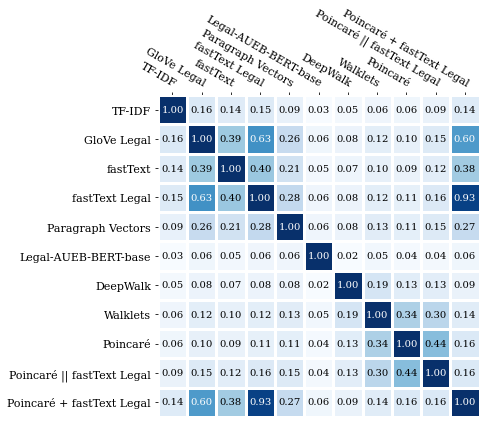

INFO:__main__:Saved to ./figures/wikisource_overlap.pdf


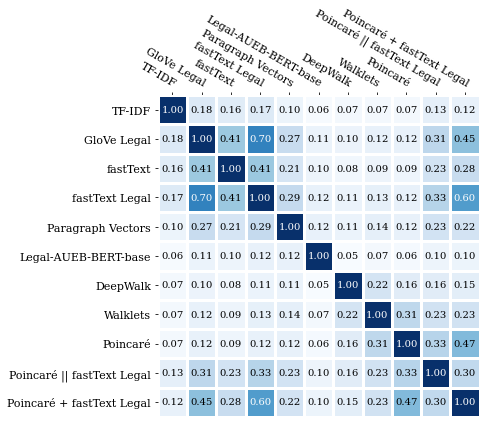

INFO:__main__:Saved to ./figures/joint_overlap.pdf


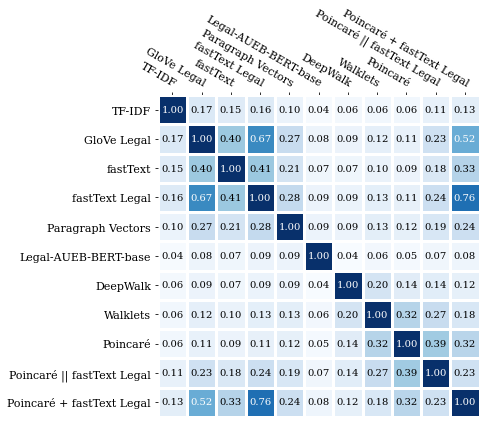

In [97]:
exp2overlaps = {}

size = (10,6)

for exp_name, exp in exps.items():
    save_file_path = f'./figures/{exp_name}_overlap.pdf'

    #systems = exp.gs.ret_docs_by_system.keys()
    overlaps = np.zeros((len(overlap_sys), len(overlap_sys)))
    
    for a_idx, a_sys_name in enumerate(overlap_sys):
        # a_ret_docs = set(exp.gs.ret_docs_by_system_and_seed[a_sys_name])
        
        for b_idx, b_sys_name in enumerate(overlap_sys):
            if a_sys_name == b_sys_name:
                overlaps[a_idx, b_idx] = 1.
                continue
                
            # seed level overlap
            overlap = []            
            for seed_id, a_ret_docs in exp.gs.ret_docs_by_system_and_seed[a_sys_name].items():
                a_ret_docs = set(a_ret_docs)
                b_ret_docs = set(exp.gs.ret_docs_by_system_and_seed[b_sys_name][seed_id])
                
                if len(a_ret_docs) > 0 and len(b_ret_docs) > 0:
                    # overlap coefficient
                    # https://en.wikipedia.org/wiki/Overlap_coefficient
                    # overlap += len(a_ret_docs & b_ret_docs) / min(len(a_ret_docs), len(b_ret_docs))
                    
                    # jacard index
                    # https://en.wikipedia.org/wiki/Jaccard_index
                    # 1 = identical
                    
                    overlap.append(
                        len(a_ret_docs & b_ret_docs) / len(a_ret_docs.union(b_ret_docs))
                    )

            overlaps[a_idx, b_idx] = np.mean(overlap)
             
    exp2overlaps[exp_name] = overlaps
            
    # Plot
    fig, ax = plt.subplots(figsize=size)
    im, cbar = heatmap(overlaps.transpose(), legend_labels, legend_labels, ax=ax,
                       cmap="Blues", #cbarlabel="Overlap among all unique recommendations [%]"
                      )
    texts = annotate_heatmap(im, valfmt="{x:.2f}")

    fig.tight_layout()


    pdf_dpi = 300

    logger.info(f'Saved to {save_file_path}')
    plt.savefig(save_file_path, bbox_inches='tight', dpi=pdf_dpi)

    plt.show()

# mean
save_file_path = f'./figures/joint_overlap.pdf'

joint_overlaps = np.mean(np.array(list(exp2overlaps.values())), axis=0)  # mean over experiments

# Plot
fig, ax = plt.subplots(figsize=size)
im, cbar = heatmap(joint_overlaps.transpose(), legend_labels, legend_labels, ax=ax,
                   cmap="Blues", #cbarlabel="Overlap among all unique recommendations [%]"
                  )
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()


pdf_dpi = 300

logger.info(f'Saved to {save_file_path}')
plt.savefig(save_file_path, bbox_inches='tight', dpi=pdf_dpi)

plt.show()



INFO:__main__:Saved to ./figures/joint_overlap.pdf


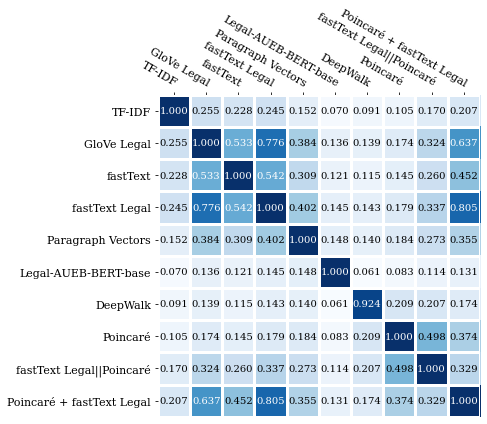

In [65]:
save_file_path = f'./figures/joint_overlap.pdf'

joint_overlaps = np.mean(np.array(list(exp2overlaps.values())), axis=0)  # mean over experiments

# Plot
fig, ax = plt.subplots(figsize=(10,6))
im, cbar = heatmap(joint_overlaps.transpose(), legend_labels, legend_labels, ax=ax,
                   cmap="Blues", #cbarlabel="Overlap among all unique recommendations [%]"
                  )
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()


pdf_dpi = 300

logger.info(f'Saved to {save_file_path}')
plt.savefig(save_file_path, bbox_inches='tight', dpi=pdf_dpi)

plt.show()


In [37]:
overlaps

array([[1.        , 0.24310595, 0.26110305, 0.11509434, 0.1107402 ,
        0.09390421, 0.20203193, 0.19492017],
       [0.24310595, 1.        , 0.55108853, 0.12714078, 0.14992743,
        0.15616836, 0.33033382, 0.39666183],
       [0.26110305, 0.55108853, 1.        , 0.16879536, 0.19100145,
        0.18650218, 0.44455733, 0.66240929],
       [0.11509434, 0.12714078, 0.16879536, 0.98911466, 0.23468795,
        0.08229318, 0.23396226, 0.21930334],
       [0.1107402 , 0.14992743, 0.19100145, 0.23468795, 1.        ,
        0.10188679, 0.45471698, 0.52859216],
       [0.09390421, 0.15616836, 0.18650218, 0.08229318, 0.10188679,
        1.        , 0.15471698, 0.16124819],
       [0.20203193, 0.33033382, 0.44455733, 0.23396226, 0.45471698,
        0.15471698, 1.        , 0.42046444],
       [0.19492017, 0.39666183, 0.66240929, 0.21930334, 0.52859216,
        0.16124819, 0.42046444, 1.        ]])

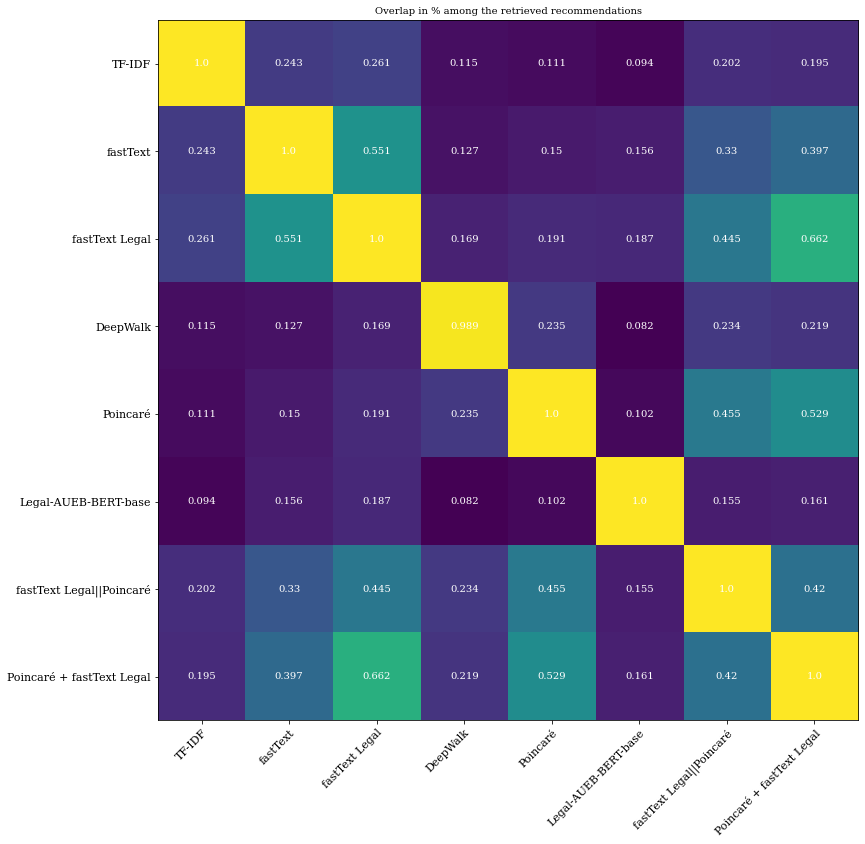

In [38]:

legend_labels = [clean_system_name(n) for n in overlap_sys]

fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(overlaps)

# We want to show all ticks...
ax.set_xticks(np.arange(len(legend_labels)))
ax.set_yticks(np.arange(len(legend_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(legend_labels)
ax.set_yticklabels(legend_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(legend_labels)):
    for j in range(len(legend_labels)):
        text = ax.text(j, i, np.round(overlaps[i, j], 3),
                       ha="center", va="center", color="w")

ax.set_title("Overlap in % among the retrieved recommendations")
fig.tight_layout()
plt.show()
